In [1]:
from monostable_model import ion_channel_model, model_force_square, random_force_gauss, random_force_levy
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown, SelectionSlider, fixed, VBox, Button
from IPython.display import display

def ion_channel_interactive(a, closed_0, closed_1, opened_0, opened_1, D, delta_t, records, model_force, random_force, **force_params):
    closed = (closed_0, closed_1)
    opened = (opened_0, opened_1)
    ion_channel_model(a, closed, opened, D, delta_t, records, model_force, random_force, **force_params)


a_slider = FloatSlider(min=0.1, max=10.0, step=0.1, value=1, description='a')
closed_0_slider = IntSlider(min=-10, max=10, step=1, value=-1, description='Closed value')
closed_1_slider = IntSlider(min=1000, max=10000, step=500, value=5000, description='Closed time scale')
opened_0_slider = IntSlider(min=-10, max=10, step=1, value=1, description='Opened value')
opened_1_slider = IntSlider(min=1000, max=10000, step=500, value=2500, description='Opened time scale')
D_slider = FloatSlider(min=0.1, max=2.0, step=0.1, value=0.5, description='D')
delta_t_slider = SelectionSlider(
    options=[10**-i for i in range(1, 5)],
    value=0.01,
    description='Delta t',
)
records_slider = IntSlider(min=1000, max=100000, step=1000, value=50000, description='Records')

model_force_dropdown=Dropdown(
        options={'Square Force': model_force_square, 'Other Force': lambda x: x**2},
        value=model_force_square,
        description='Model Force',
)

random_force_dropdown = Dropdown(
    options={'Gauss Force': random_force_gauss, 'Levy Force': random_force_levy},
    value=random_force_gauss,
    description='Random Force',
)

force_params_box = VBox()

def update_force_params(*args):
    force_type = random_force_dropdown.value
    print(force_type)
    if force_type == 'stable':
        # Define widgets specific to 'Other Force'
        alpha = FloatSlider(min=0, max=2, step=0.01, value=0.5, description='alpha')
        beta = FloatSlider(min=-1, max=1, step=0.01, value=0, description='beta')
        loc = FloatSlider(min=0, max=100, step=1, value=0, description='location')
        scale = FloatSlider(min=0, max=100, step=0.1, value=1, description='scale')
        force_params_box.children = [alpha, beta, loc, scale]
    else:
        force_params_box.children = []

random_force_dropdown.observe(update_force_params, names='value')

display(
    a_slider,
    closed_0_slider,
    closed_1_slider,
    opened_0_slider,
    opened_1_slider,
    D_slider,
    delta_t_slider,
    records_slider,
    model_force_dropdown,
    force_params_box,
    random_force_dropdown
)

def on_button_click(b):
    force_params = {child.description: child.value for child in force_params_box.children}
    print(force_params)
    ion_channel_interactive(
        a_slider.value,
        closed_0_slider.value,
        closed_1_slider.value,
        opened_0_slider.value,
        opened_1_slider.value,
        D_slider.value,
        delta_t_slider.value,
        records_slider.value,
        model_force_dropdown.value,
        random_force_dropdown.value,
        **force_params
    )

run_button = Button(description="Run Model")
run_button.on_click(on_button_click)
display(run_button)

# # Interact with the function
# interact(
#     ion_channel_interactive,
#     a=FloatSlider(min=0.1, max=10.0, step=0.1, value=1, description='a'),
#     closed_0=IntSlider(min=-10, max=10, step=1, value=-1, description='Closed value'),
#     closed_1=IntSlider(min=1000, max=10000, step=500, value=5000, description='Closed time scale'),
#     opened_0=IntSlider(min=-10, max=10, step=1, value=1, description='Opened value'),
#     opened_1=IntSlider(min=1000, max=10000, step=500, value=2500, description='Opened time scale'),
#     D=FloatSlider(min=0.1, max=2.0, step=0.1, value=0.5, description='D'),
#     delta_t=SelectionSlider(
#         options=[10**-i for i in range(1, 5)],
#         value=0.01,
#         description='Delta t',
#     ),
#     records=IntSlider(min=1000, max=100000, step=1000, value=50000, description='Records'),
    
#     random_force=Dropdown(
#     options={'Gauss Force': random_force_gauss, 'Levy Force': random_force_levy},
#     value=random_force_gauss,
#     description='Model Force',
#     )
# )

FloatSlider(value=1.0, description='a', max=10.0, min=0.1)

IntSlider(value=-1, description='Closed value', max=10, min=-10)

IntSlider(value=5000, description='Closed time scale', max=10000, min=1000, step=500)

IntSlider(value=1, description='Opened value', max=10, min=-10)

IntSlider(value=2500, description='Opened time scale', max=10000, min=1000, step=500)

FloatSlider(value=0.5, description='D', max=2.0, min=0.1)

SelectionSlider(description='Delta t', index=1, options=(0.1, 0.01, 0.001, 0.0001), value=0.01)

IntSlider(value=50000, description='Records', max=100000, min=1000, step=1000)

Dropdown(description='Model Force', options={'Square Force': <function model_force_square at 0x7f962a8a5760>, …

VBox()

Dropdown(description='Random Force', options={'Gauss Force': <function random_force_gauss at 0x7f96405213a0>, …

Button(description='Run Model', style=ButtonStyle())

{}


TypeError: random_force_gauss() takes 2 positional arguments but 3 were given

<function random_force_levy at 0x7f95c4939300>
{}
{}


TypeError: '>' not supported between instances of 'dict' and 'int'

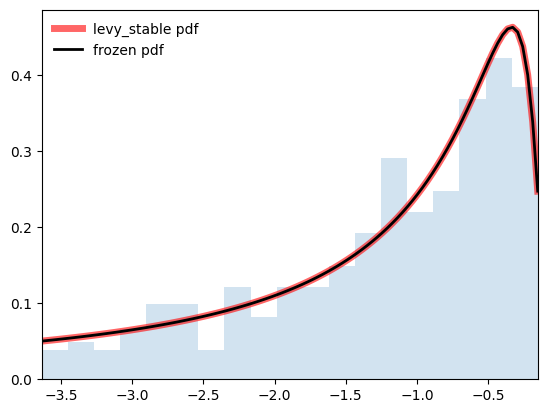

In [ ]:
import numpy as np
from scipy.stats import levy_stable, levy, levy_l
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

alpha, beta = 0.5, -1
loc, scale = 0, 1
# x = np.linspace(levy_stable.ppf(0.01, alpha, beta, loc=loc, scale=scale),
#                 levy_stable.ppf(0.99, alpha, beta, loc=loc, scale=scale), 100)
# ax.plot(x, levy_stable.pdf(x, alpha, beta, loc=loc, scale=scale),
#        'r-', lw=5, alpha=0.6, label='levy_stable pdf')

a = levy_stable.ppf(0.4, alpha, beta, loc=loc, scale=scale)
b = levy_stable.ppf(0.99, alpha, beta, loc=loc, scale=scale)

x = np.linspace(a, b, 100)
ax.plot(x, levy_stable.pdf(x, alpha, beta, loc=loc, scale=scale),
       'r-', lw=5, alpha=0.6, label='levy_stable pdf')


rv = levy_stable(alpha, beta, loc=loc, scale=scale)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

vals = levy_stable.ppf([0.001, 0.5, 0.999], alpha, beta, loc=loc, scale=scale)
np.allclose([0.001, 0.5, 0.999], levy_stable.cdf(vals, alpha, beta, loc=loc, scale=scale))

r = levy_stable.rvs(alpha, beta, loc=loc, scale=scale, size=1000)

bins = np.concatenate(([np.min(r)], np.linspace(a, b, 20)))
ax.hist(r, density=True, bins=bins, histtype='stepfilled', alpha=0.2)
ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best', frameon=False)
plt.show()

In [3]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import levy_stable

# Parameters
alpha, beta = 0.5, 1
loc, scale = 0, 1

# Generate data for PDF
x = np.linspace(levy_stable.ppf(0.01, alpha, beta, loc=loc, scale=scale),
                levy_stable.ppf(0.99, alpha, beta, loc=loc, scale=scale), 100)
pdf = levy_stable.pdf(x, alpha, beta, loc=loc, scale=scale)

# Generate random samples
r = levy_stable.rvs(alpha, beta, loc=loc, scale=scale, size=100)

# Create the figure
fig = go.Figure()

# Add ProbabilityDensityFunction curve
fig.add_trace(go.Scatter(x=x, y=pdf, mode='lines', name='Lévy-stable PDF'))

# Add histogram
fig.add_trace(go.Histogram(x=r, histnorm='probability density', opacity=0.6, name='Histogram'))

# Customize layout
fig.update_layout(
    title="Interactive Lévy-Stable Distribution",
    xaxis_title="Value",
    yaxis_title="Density",
    legend=dict(x=0.02, y=0.98),
    template="plotly_dark"
)

# Show interactive plot
fig.show()


In [71]:
random_force_gauss(0.5, 0.01)

0.024351238081335862

In [92]:
import importlib
import monostable_model
importlib.reload(monostable_model)

while True:
    a = monostable_model.random_force_levy(0.5, 0.01, alpha=0.5, beta=0, loc=0, scale=1)
    if a > 10**5:
        break
    print(a)

-1.7330967055103939
0.008747294976574236
15.104021454920407
-0.09354878755133259
0.042500641638573616
0.1007409768482338
0.5707287535243194
1.6028281525888706
-0.10044075916354091
1.0550204007942057
-0.0046037784970331406
0.24812873349652664
-0.05571253056116543
-0.5316966633034159
-0.04311223327481209
0.06315565714487793
50.81991435865267
0.0015356777288950308
2.653341811233961
-3.8992530270013175
-0.4899412961985583
0.06578402277481328
-0.10965304334661141
0.5653035231716566
-0.009620766648606413
-0.11252039145966063
-0.03491376312086339
0.008321556899976443
0.3078534000422355
-0.008297346618333555
0.13295510390163523
0.017360831649303212
-0.22127456870274095
0.0008309168405638793
-0.026226429462470703
-0.08765470304018164
-0.39217844390284345
-1.212929322901958
-0.0025604771243938713
-0.7300324242364856
0.12316788040055898
-0.008080250939536923
0.0653733653584456
-0.05390690551736035
14.576928517412282
0.008358363966624848
-0.02189330045875192
-1.2397892192287785
-0.0004677910617894